In [1]:
! pip install tensorflow==2.0.0

  Created wheel for opt-einsum: filename=opt_einsum-3.1.0-cp37-none-any.whl size=61701 sha256=6ae6a746eb3c30388a62f23f2da1c0fce43fea97935891f6fc268fd162cd3309
  Stored in directory: C:\Users\arsha\AppData\Local\pip\Cache\wheels\2c\b1\94\43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7545 sha256=afa53b0e61faa34ccc3631309f9ead2b311945e8f3c8dac1ef3e1332c97f0f29
  Stored in directory: C:\Users\arsha\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built opt-einsum gast
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: gast 0.3.2
    Uninstalling gast-0.3.2:
      Successfully uninstalled gast-0.3.2
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorb

### Importing dependencies

In [4]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
tf.__version__

'2.0.0'

### Importing the dataset

In [6]:
# Importing dataset
(X_train_g, y_train), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 4s 1us/step


### Visualization

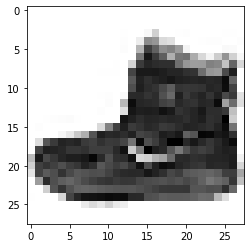

In [8]:
plt.imshow(X_train_g[0], cmap='Greys')

In [9]:
X_train_g.shape

(60000, 28, 28)

### Creating the generator and the discriminator

In [10]:
def create_generator():
  
  model = Sequential()
  
  model.add(Dense(256, input_dim=100))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(np.prod(img_shape), activation='tanh'))
  model.add(Reshape(img_shape))
  
  model.summary()
  
  noise = Input(shape=(100,))
  img = model(noise)
  
  return Model(noise, img)

In [11]:
def create_discriminator():
  
  model = Sequential()
  
  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))
  
  model.summary()
  
  img = Input(shape=img_shape)
  validity = model(img)
  
  return Model(img, validity)

### Training both neural networks

In [12]:
def train(epochs, batch_size=128, sample_interval=50):
  
  # First we need to rescale the training examples
  X_train = X_train_g / 127.5 - 1
  # We need to add a fake axis to X_train, channels dimension
  X_train = np.expand_dims(X_train, axis=3)
  
  # This is what we want from the dicriminator:
  # Predict 1 for a valid image and 0 for a fake one
  valid = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))
  
  for epoch in range(epochs):
    
    # Training the discriminator
    
    # We take a random sample from the training examples of size batch_size
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    
    # We also create fake images (random noise to start)
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs =  generator.predict(noise)
    
    # We train the discriminator on both the fake images and the real ones
    # We compute the loss for each set
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    
    # We calculate the average loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Training the generator
    
    g_loss = combined.train_on_batch(noise, valid)
    
    # Plot the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
    
    # Here we display images showing the generator progress
    if epoch % sample_interval == 0:
      generator_progress(epoch)

### Displaying the generator progress

In [13]:
def generator_progress(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r * c, 100))
  gen_imgs = generator.predict(noise)
  
  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
          axs[i,j].axis('off')
          cnt += 1
  #fig.savefig("images/%d.png" % epoch)
  plt.show()
  plt.close()

### Running the whole code

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
__________________________________________________

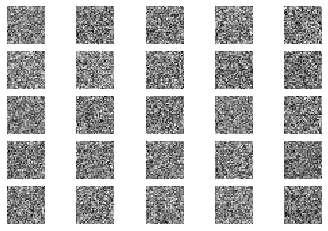

1 [D loss: 0.372374, acc.: 0.00%] [G loss: 0.678896]
2 [D loss: 0.355991, acc.: 0.00%] [G loss: 0.687403]
3 [D loss: 0.346386, acc.: 0.00%] [G loss: 0.775625]
4 [D loss: 0.316473, acc.: 0.00%] [G loss: 0.885936]
5 [D loss: 0.299748, acc.: 0.00%] [G loss: 1.046273]
6 [D loss: 0.266344, acc.: 0.00%] [G loss: 1.186008]
7 [D loss: 0.229496, acc.: 0.00%] [G loss: 1.421073]
8 [D loss: 0.185944, acc.: 0.00%] [G loss: 1.600361]
9 [D loss: 0.166415, acc.: 0.00%] [G loss: 1.782521]
10 [D loss: 0.147984, acc.: 0.00%] [G loss: 1.993030]
11 [D loss: 0.139869, acc.: 0.00%] [G loss: 2.079637]
12 [D loss: 0.095557, acc.: 0.00%] [G loss: 2.300205]
13 [D loss: 0.091206, acc.: 0.00%] [G loss: 2.378765]
14 [D loss: 0.085327, acc.: 0.00%] [G loss: 2.484452]
15 [D loss: 0.065250, acc.: 0.00%] [G loss: 2.530673]
16 [D loss: 0.084558, acc.: 0.00%] [G loss: 2.738270]
17 [D loss: 0.047684, acc.: 0.00%] [G loss: 2.776684]
18 [D loss: 0.060912, acc.: 0.00%] [G loss: 2.772133]
19 [D loss: 0.051179, acc.: 0.00%] [G

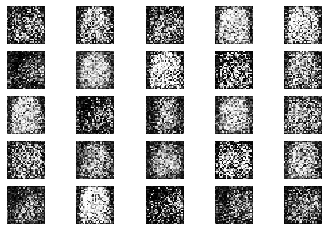

201 [D loss: 0.467123, acc.: 0.00%] [G loss: 2.185912]
202 [D loss: 0.477431, acc.: 0.00%] [G loss: 2.454690]
203 [D loss: 0.453861, acc.: 0.00%] [G loss: 3.065450]
204 [D loss: 0.492560, acc.: 0.00%] [G loss: 2.841652]
205 [D loss: 0.325570, acc.: 0.00%] [G loss: 2.593536]
206 [D loss: 0.382046, acc.: 0.00%] [G loss: 2.543165]
207 [D loss: 0.305774, acc.: 0.00%] [G loss: 2.935578]
208 [D loss: 0.415028, acc.: 0.00%] [G loss: 2.262014]
209 [D loss: 0.485584, acc.: 0.00%] [G loss: 2.587667]
210 [D loss: 0.330553, acc.: 0.00%] [G loss: 3.069328]
211 [D loss: 0.411146, acc.: 0.00%] [G loss: 2.744868]
212 [D loss: 0.529020, acc.: 0.00%] [G loss: 2.374144]
213 [D loss: 0.276257, acc.: 0.00%] [G loss: 2.619639]
214 [D loss: 0.413320, acc.: 0.00%] [G loss: 2.000302]
215 [D loss: 0.248180, acc.: 0.00%] [G loss: 2.818903]
216 [D loss: 0.703528, acc.: 0.00%] [G loss: 2.740986]
217 [D loss: 0.464108, acc.: 0.00%] [G loss: 2.649307]
218 [D loss: 0.642657, acc.: 0.00%] [G loss: 2.588416]
219 [D los

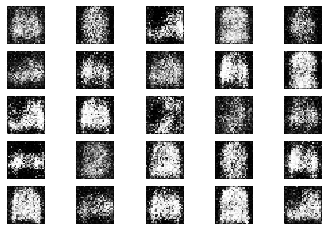

401 [D loss: 0.580967, acc.: 0.00%] [G loss: 1.052851]
402 [D loss: 0.645679, acc.: 0.00%] [G loss: 0.954621]
403 [D loss: 0.594355, acc.: 0.00%] [G loss: 0.985045]
404 [D loss: 0.671408, acc.: 0.00%] [G loss: 1.035875]
405 [D loss: 0.538694, acc.: 0.00%] [G loss: 1.042629]
406 [D loss: 0.632608, acc.: 0.00%] [G loss: 1.040915]
407 [D loss: 0.615741, acc.: 0.00%] [G loss: 0.976426]
408 [D loss: 0.642176, acc.: 0.00%] [G loss: 0.979403]
409 [D loss: 0.533864, acc.: 0.00%] [G loss: 1.009258]
410 [D loss: 0.629169, acc.: 0.00%] [G loss: 1.005239]
411 [D loss: 0.647913, acc.: 0.00%] [G loss: 1.026943]
412 [D loss: 0.591900, acc.: 0.00%] [G loss: 1.080399]
413 [D loss: 0.583501, acc.: 0.00%] [G loss: 1.013384]
414 [D loss: 0.561019, acc.: 0.00%] [G loss: 1.019466]
415 [D loss: 0.610752, acc.: 0.00%] [G loss: 1.012372]
416 [D loss: 0.624393, acc.: 0.00%] [G loss: 1.018843]
417 [D loss: 0.681196, acc.: 0.00%] [G loss: 0.930029]
418 [D loss: 0.671537, acc.: 0.00%] [G loss: 0.895610]
419 [D los

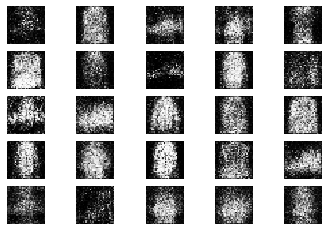

601 [D loss: 0.647807, acc.: 0.00%] [G loss: 0.835122]
602 [D loss: 0.676831, acc.: 0.00%] [G loss: 0.879306]
603 [D loss: 0.599451, acc.: 0.00%] [G loss: 0.950090]
604 [D loss: 0.633049, acc.: 0.00%] [G loss: 0.883843]
605 [D loss: 0.586184, acc.: 0.00%] [G loss: 0.958259]
606 [D loss: 0.612595, acc.: 0.00%] [G loss: 0.902575]
607 [D loss: 0.585030, acc.: 0.00%] [G loss: 0.856513]
608 [D loss: 0.679848, acc.: 0.00%] [G loss: 0.932979]
609 [D loss: 0.607012, acc.: 0.00%] [G loss: 0.937006]
610 [D loss: 0.598427, acc.: 0.00%] [G loss: 0.945170]
611 [D loss: 0.664079, acc.: 0.00%] [G loss: 0.974640]
612 [D loss: 0.626847, acc.: 0.00%] [G loss: 0.931896]
613 [D loss: 0.603683, acc.: 0.00%] [G loss: 0.890529]
614 [D loss: 0.617673, acc.: 0.00%] [G loss: 0.943642]
615 [D loss: 0.620890, acc.: 0.00%] [G loss: 0.846696]
616 [D loss: 0.629991, acc.: 0.00%] [G loss: 0.927564]
617 [D loss: 0.654296, acc.: 0.00%] [G loss: 0.936354]
618 [D loss: 0.610880, acc.: 0.00%] [G loss: 0.922073]
619 [D los

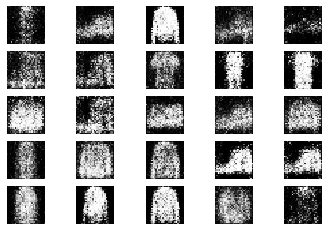

801 [D loss: 0.610993, acc.: 0.00%] [G loss: 0.893212]
802 [D loss: 0.562648, acc.: 0.00%] [G loss: 0.942641]
803 [D loss: 0.670521, acc.: 0.00%] [G loss: 0.862924]
804 [D loss: 0.668851, acc.: 0.00%] [G loss: 0.882554]
805 [D loss: 0.570176, acc.: 0.00%] [G loss: 0.886822]
806 [D loss: 0.591689, acc.: 0.00%] [G loss: 0.907415]
807 [D loss: 0.644828, acc.: 0.00%] [G loss: 0.841059]
808 [D loss: 0.636681, acc.: 0.00%] [G loss: 0.900329]
809 [D loss: 0.611922, acc.: 0.00%] [G loss: 0.881574]
810 [D loss: 0.625497, acc.: 0.00%] [G loss: 0.994470]
811 [D loss: 0.653565, acc.: 0.00%] [G loss: 0.940400]
812 [D loss: 0.593114, acc.: 0.00%] [G loss: 0.920173]
813 [D loss: 0.667438, acc.: 0.00%] [G loss: 0.862824]
814 [D loss: 0.641804, acc.: 0.00%] [G loss: 0.885351]
815 [D loss: 0.621608, acc.: 0.00%] [G loss: 0.787602]
816 [D loss: 0.574876, acc.: 0.00%] [G loss: 0.957162]
817 [D loss: 0.653299, acc.: 0.00%] [G loss: 0.855094]
818 [D loss: 0.701794, acc.: 0.00%] [G loss: 0.834451]
819 [D los

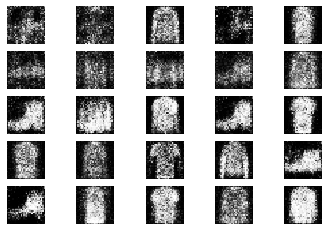

1001 [D loss: 0.605860, acc.: 0.00%] [G loss: 0.900924]
1002 [D loss: 0.657189, acc.: 0.00%] [G loss: 0.856481]
1003 [D loss: 0.689613, acc.: 0.00%] [G loss: 0.813196]
1004 [D loss: 0.553138, acc.: 0.00%] [G loss: 0.922384]
1005 [D loss: 0.609964, acc.: 0.00%] [G loss: 0.873330]
1006 [D loss: 0.597683, acc.: 0.00%] [G loss: 0.914544]
1007 [D loss: 0.634316, acc.: 0.00%] [G loss: 0.889310]
1008 [D loss: 0.695310, acc.: 0.00%] [G loss: 0.874495]
1009 [D loss: 0.572594, acc.: 0.00%] [G loss: 0.925288]
1010 [D loss: 0.676769, acc.: 0.00%] [G loss: 0.896544]
1011 [D loss: 0.631393, acc.: 0.00%] [G loss: 0.941006]
1012 [D loss: 0.687357, acc.: 0.00%] [G loss: 0.824728]
1013 [D loss: 0.636335, acc.: 0.00%] [G loss: 1.005905]
1014 [D loss: 0.650786, acc.: 0.00%] [G loss: 0.873848]
1015 [D loss: 0.682935, acc.: 0.00%] [G loss: 0.850815]
1016 [D loss: 0.609727, acc.: 0.00%] [G loss: 0.882490]
1017 [D loss: 0.600807, acc.: 0.00%] [G loss: 0.887956]
1018 [D loss: 0.627423, acc.: 0.00%] [G loss: 0.

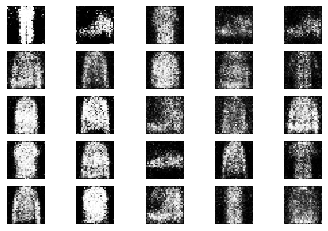

1201 [D loss: 0.619118, acc.: 0.00%] [G loss: 0.948940]
1202 [D loss: 0.646198, acc.: 0.00%] [G loss: 0.882879]
1203 [D loss: 0.599879, acc.: 0.00%] [G loss: 0.931033]
1204 [D loss: 0.677051, acc.: 0.00%] [G loss: 0.866455]
1205 [D loss: 0.552884, acc.: 0.00%] [G loss: 0.945023]
1206 [D loss: 0.699318, acc.: 0.00%] [G loss: 0.849197]
1207 [D loss: 0.596009, acc.: 0.00%] [G loss: 0.895286]
1208 [D loss: 0.650022, acc.: 0.00%] [G loss: 0.891020]
1209 [D loss: 0.598294, acc.: 0.00%] [G loss: 0.905086]
1210 [D loss: 0.675584, acc.: 0.00%] [G loss: 0.851738]
1211 [D loss: 0.561914, acc.: 0.00%] [G loss: 0.972015]
1212 [D loss: 0.693081, acc.: 0.00%] [G loss: 0.885437]
1213 [D loss: 0.626112, acc.: 0.00%] [G loss: 0.944900]
1214 [D loss: 0.654181, acc.: 0.00%] [G loss: 0.889803]
1215 [D loss: 0.657064, acc.: 0.00%] [G loss: 0.894862]
1216 [D loss: 0.714427, acc.: 0.00%] [G loss: 0.848742]
1217 [D loss: 0.670708, acc.: 0.00%] [G loss: 0.791795]
1218 [D loss: 0.580672, acc.: 0.00%] [G loss: 0.

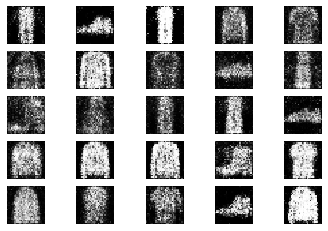

1401 [D loss: 0.670253, acc.: 0.00%] [G loss: 0.839427]
1402 [D loss: 0.638523, acc.: 0.00%] [G loss: 0.870747]
1403 [D loss: 0.652340, acc.: 0.00%] [G loss: 0.863469]
1404 [D loss: 0.615381, acc.: 0.00%] [G loss: 0.872460]
1405 [D loss: 0.641360, acc.: 0.00%] [G loss: 0.847347]
1406 [D loss: 0.696131, acc.: 0.00%] [G loss: 0.944578]
1407 [D loss: 0.625500, acc.: 0.00%] [G loss: 0.942509]
1408 [D loss: 0.717985, acc.: 0.00%] [G loss: 0.869919]
1409 [D loss: 0.594557, acc.: 0.00%] [G loss: 0.871033]
1410 [D loss: 0.584011, acc.: 0.00%] [G loss: 0.899649]
1411 [D loss: 0.598764, acc.: 0.00%] [G loss: 0.875361]
1412 [D loss: 0.653009, acc.: 0.00%] [G loss: 0.833388]
1413 [D loss: 0.592303, acc.: 0.00%] [G loss: 0.894482]
1414 [D loss: 0.672989, acc.: 0.00%] [G loss: 0.830729]
1415 [D loss: 0.626653, acc.: 0.00%] [G loss: 0.940508]
1416 [D loss: 0.590107, acc.: 0.00%] [G loss: 0.926711]
1417 [D loss: 0.657337, acc.: 0.00%] [G loss: 0.855889]
1418 [D loss: 0.640487, acc.: 0.00%] [G loss: 0.

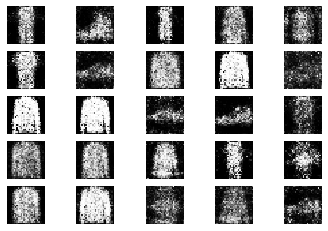

1601 [D loss: 0.643068, acc.: 0.00%] [G loss: 0.913746]
1602 [D loss: 0.611307, acc.: 0.00%] [G loss: 0.941756]
1603 [D loss: 0.577120, acc.: 0.00%] [G loss: 0.900125]
1604 [D loss: 0.654561, acc.: 0.00%] [G loss: 0.925150]
1605 [D loss: 0.587794, acc.: 0.00%] [G loss: 0.878984]
1606 [D loss: 0.643002, acc.: 0.00%] [G loss: 0.895523]
1607 [D loss: 0.709453, acc.: 0.00%] [G loss: 0.862307]
1608 [D loss: 0.590289, acc.: 0.00%] [G loss: 0.915140]
1609 [D loss: 0.671392, acc.: 0.00%] [G loss: 0.877129]
1610 [D loss: 0.585101, acc.: 0.00%] [G loss: 0.925691]
1611 [D loss: 0.654451, acc.: 0.00%] [G loss: 0.876868]
1612 [D loss: 0.685829, acc.: 0.00%] [G loss: 0.893523]
1613 [D loss: 0.653094, acc.: 0.00%] [G loss: 0.900820]
1614 [D loss: 0.665387, acc.: 0.00%] [G loss: 0.865634]
1615 [D loss: 0.593332, acc.: 0.00%] [G loss: 0.900119]
1616 [D loss: 0.670058, acc.: 0.00%] [G loss: 0.864388]
1617 [D loss: 0.730977, acc.: 0.00%] [G loss: 0.887534]
1618 [D loss: 0.622556, acc.: 0.00%] [G loss: 0.

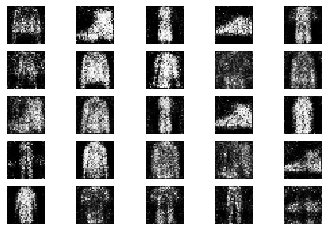

1801 [D loss: 0.645405, acc.: 0.00%] [G loss: 0.921030]
1802 [D loss: 0.624137, acc.: 0.00%] [G loss: 0.990150]
1803 [D loss: 0.660262, acc.: 0.00%] [G loss: 0.996437]
1804 [D loss: 0.616432, acc.: 0.00%] [G loss: 0.956272]
1805 [D loss: 0.704337, acc.: 0.00%] [G loss: 0.873936]
1806 [D loss: 0.618669, acc.: 0.00%] [G loss: 0.936297]
1807 [D loss: 0.636337, acc.: 0.00%] [G loss: 0.909101]
1808 [D loss: 0.622032, acc.: 0.00%] [G loss: 1.006101]
1809 [D loss: 0.591535, acc.: 0.00%] [G loss: 0.907004]
1810 [D loss: 0.662646, acc.: 0.00%] [G loss: 0.951398]
1811 [D loss: 0.638058, acc.: 0.00%] [G loss: 0.948820]
1812 [D loss: 0.638255, acc.: 0.00%] [G loss: 0.902758]
1813 [D loss: 0.606834, acc.: 0.00%] [G loss: 0.870899]
1814 [D loss: 0.612178, acc.: 0.00%] [G loss: 0.980663]
1815 [D loss: 0.651840, acc.: 0.00%] [G loss: 1.010815]
1816 [D loss: 0.658206, acc.: 0.00%] [G loss: 0.943340]
1817 [D loss: 0.658387, acc.: 0.00%] [G loss: 0.886396]
1818 [D loss: 0.630387, acc.: 0.00%] [G loss: 0.

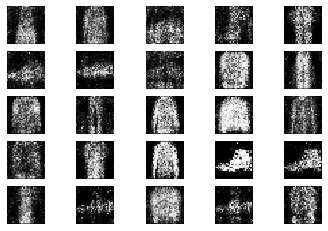

2001 [D loss: 0.598245, acc.: 0.00%] [G loss: 0.902695]
2002 [D loss: 0.673401, acc.: 0.00%] [G loss: 0.867647]
2003 [D loss: 0.604166, acc.: 0.00%] [G loss: 0.935986]
2004 [D loss: 0.693687, acc.: 0.00%] [G loss: 0.849387]
2005 [D loss: 0.624663, acc.: 0.00%] [G loss: 0.890376]
2006 [D loss: 0.650555, acc.: 0.00%] [G loss: 0.889507]
2007 [D loss: 0.730690, acc.: 0.00%] [G loss: 0.842164]
2008 [D loss: 0.616486, acc.: 0.00%] [G loss: 0.923702]
2009 [D loss: 0.672664, acc.: 0.00%] [G loss: 0.946264]
2010 [D loss: 0.658785, acc.: 0.00%] [G loss: 0.908270]
2011 [D loss: 0.701891, acc.: 0.00%] [G loss: 0.946249]
2012 [D loss: 0.607378, acc.: 0.00%] [G loss: 0.904788]
2013 [D loss: 0.707847, acc.: 0.00%] [G loss: 0.894170]
2014 [D loss: 0.671970, acc.: 0.00%] [G loss: 0.865577]
2015 [D loss: 0.658631, acc.: 0.00%] [G loss: 0.910648]
2016 [D loss: 0.630435, acc.: 0.00%] [G loss: 0.885734]
2017 [D loss: 0.605395, acc.: 0.00%] [G loss: 0.925734]
2018 [D loss: 0.579643, acc.: 0.00%] [G loss: 0.

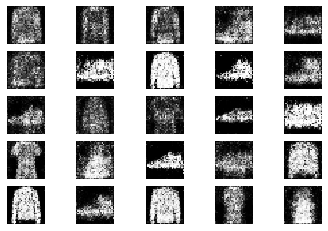

2201 [D loss: 0.640391, acc.: 0.00%] [G loss: 0.938962]
2202 [D loss: 0.620756, acc.: 0.00%] [G loss: 0.966624]
2203 [D loss: 0.607182, acc.: 0.00%] [G loss: 0.946698]
2204 [D loss: 0.667073, acc.: 0.00%] [G loss: 0.897046]
2205 [D loss: 0.670608, acc.: 0.00%] [G loss: 0.867774]
2206 [D loss: 0.604977, acc.: 0.00%] [G loss: 0.931256]
2207 [D loss: 0.666734, acc.: 0.00%] [G loss: 0.883942]
2208 [D loss: 0.668538, acc.: 0.00%] [G loss: 0.866904]
2209 [D loss: 0.663729, acc.: 0.00%] [G loss: 0.835550]
2210 [D loss: 0.616794, acc.: 0.00%] [G loss: 0.951333]
2211 [D loss: 0.594811, acc.: 0.00%] [G loss: 0.901232]
2212 [D loss: 0.604776, acc.: 0.00%] [G loss: 0.979692]
2213 [D loss: 0.691344, acc.: 0.00%] [G loss: 0.869395]
2214 [D loss: 0.626342, acc.: 0.00%] [G loss: 0.927540]
2215 [D loss: 0.650353, acc.: 0.00%] [G loss: 0.881914]
2216 [D loss: 0.587112, acc.: 0.00%] [G loss: 0.891476]
2217 [D loss: 0.692246, acc.: 0.00%] [G loss: 0.905837]
2218 [D loss: 0.614355, acc.: 0.00%] [G loss: 0.

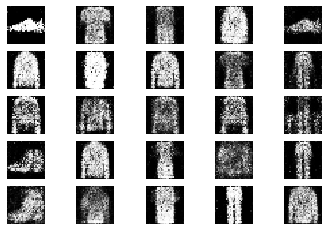

2401 [D loss: 0.581069, acc.: 0.00%] [G loss: 0.953650]
2402 [D loss: 0.616575, acc.: 0.00%] [G loss: 0.936510]
2403 [D loss: 0.633754, acc.: 0.00%] [G loss: 0.934170]
2404 [D loss: 0.615918, acc.: 0.00%] [G loss: 0.962452]
2405 [D loss: 0.587014, acc.: 0.00%] [G loss: 0.973689]
2406 [D loss: 0.640668, acc.: 0.00%] [G loss: 0.904404]
2407 [D loss: 0.653358, acc.: 0.00%] [G loss: 0.920716]
2408 [D loss: 0.589742, acc.: 0.00%] [G loss: 0.977698]
2409 [D loss: 0.600047, acc.: 0.00%] [G loss: 0.901193]
2410 [D loss: 0.635152, acc.: 0.00%] [G loss: 0.926411]
2411 [D loss: 0.654988, acc.: 0.00%] [G loss: 0.933912]
2412 [D loss: 0.704522, acc.: 0.00%] [G loss: 0.956561]
2413 [D loss: 0.585598, acc.: 0.00%] [G loss: 0.911485]
2414 [D loss: 0.677215, acc.: 0.00%] [G loss: 0.939530]
2415 [D loss: 0.665492, acc.: 0.00%] [G loss: 0.974465]
2416 [D loss: 0.616337, acc.: 0.00%] [G loss: 0.910974]
2417 [D loss: 0.636721, acc.: 0.00%] [G loss: 0.930705]
2418 [D loss: 0.712866, acc.: 0.00%] [G loss: 0.

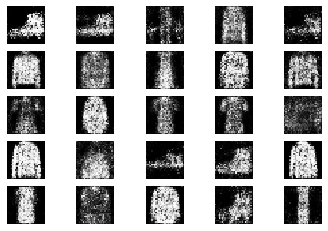

2601 [D loss: 0.564256, acc.: 0.00%] [G loss: 0.925386]
2602 [D loss: 0.694679, acc.: 0.00%] [G loss: 0.960039]
2603 [D loss: 0.648051, acc.: 0.00%] [G loss: 0.863219]
2604 [D loss: 0.636681, acc.: 0.00%] [G loss: 0.989252]
2605 [D loss: 0.608723, acc.: 0.00%] [G loss: 0.952646]
2606 [D loss: 0.642966, acc.: 0.00%] [G loss: 0.960561]
2607 [D loss: 0.619669, acc.: 0.00%] [G loss: 0.945797]
2608 [D loss: 0.641232, acc.: 0.00%] [G loss: 0.995839]
2609 [D loss: 0.658899, acc.: 0.00%] [G loss: 1.073184]
2610 [D loss: 0.667011, acc.: 0.00%] [G loss: 1.009464]
2611 [D loss: 0.691096, acc.: 0.00%] [G loss: 0.931657]
2612 [D loss: 0.620852, acc.: 0.00%] [G loss: 0.918727]
2613 [D loss: 0.626380, acc.: 0.00%] [G loss: 0.960251]
2614 [D loss: 0.602589, acc.: 0.00%] [G loss: 0.954846]
2615 [D loss: 0.601885, acc.: 0.00%] [G loss: 0.976084]
2616 [D loss: 0.691052, acc.: 0.00%] [G loss: 0.963221]
2617 [D loss: 0.635018, acc.: 0.00%] [G loss: 1.089743]
2618 [D loss: 0.669764, acc.: 0.00%] [G loss: 0.

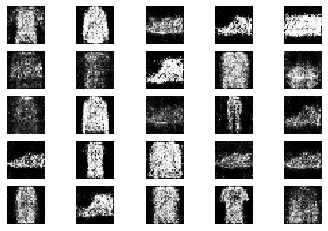

2801 [D loss: 0.591651, acc.: 0.00%] [G loss: 0.987778]
2802 [D loss: 0.675020, acc.: 0.00%] [G loss: 0.868411]
2803 [D loss: 0.617660, acc.: 0.00%] [G loss: 0.919000]
2804 [D loss: 0.616025, acc.: 0.00%] [G loss: 0.932355]
2805 [D loss: 0.589986, acc.: 0.00%] [G loss: 0.942532]
2806 [D loss: 0.674188, acc.: 0.00%] [G loss: 0.865728]
2807 [D loss: 0.616636, acc.: 0.00%] [G loss: 0.914311]
2808 [D loss: 0.625815, acc.: 0.00%] [G loss: 0.916521]
2809 [D loss: 0.634047, acc.: 0.00%] [G loss: 0.935665]
2810 [D loss: 0.670033, acc.: 0.00%] [G loss: 0.877920]
2811 [D loss: 0.624609, acc.: 0.00%] [G loss: 0.941229]
2812 [D loss: 0.634062, acc.: 0.00%] [G loss: 0.886271]
2813 [D loss: 0.677415, acc.: 0.00%] [G loss: 0.873591]
2814 [D loss: 0.690873, acc.: 0.00%] [G loss: 0.885138]
2815 [D loss: 0.632595, acc.: 0.00%] [G loss: 0.926977]
2816 [D loss: 0.651784, acc.: 0.00%] [G loss: 0.877093]
2817 [D loss: 0.545167, acc.: 0.00%] [G loss: 0.971985]
2818 [D loss: 0.625233, acc.: 0.00%] [G loss: 0.

In [14]:
# Setting global variables
epochs = 3000
batch_size = 32
sample_interval = 200
img_shape =(28,28,1)
optimizer = Adam(0.0002, 0.5)

# Building and compiling the discriminator
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['Accuracy'])

# Building the generator
generator = create_generator()

noise = Input(shape=(100,))
img = generator(noise)

# Making the discriminator not trainable (we just want to create good fake images)
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(noise, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# Training the combined model
train(epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)

### Showing results

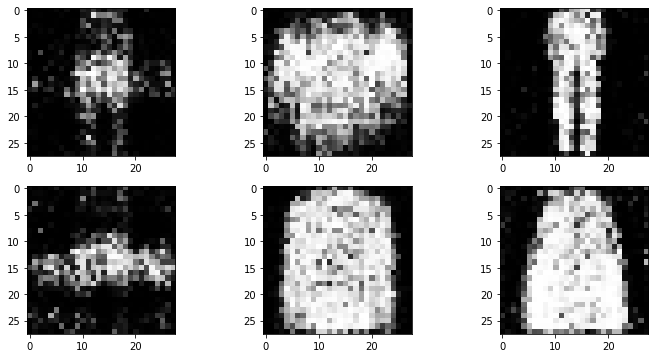

In [15]:
# We set the number of observations
n_obs = 6

# We generate random noise and create fake images using our trained generator
noise = np.random.normal(0, 1, (n_obs, 100))
gen_imgs = generator.predict(noise)

gen_imgs = 0.5*gen_imgs+0.5

plt.figure(figsize=(12, 6))

# First row
plt.subplot(231)
plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
plt.subplot(232)
plt.imshow(gen_imgs[1, :, :, 0], cmap='gray')
plt.subplot(233)
plt.imshow(gen_imgs[2, :, :, 0], cmap='gray')


# Second row
plt.subplot(234)
plt.imshow(gen_imgs[3, :, :, 0], cmap='gray')
plt.subplot(235)
plt.imshow(gen_imgs[4, :, :, 0], cmap='gray')
plt.subplot(236)
plt.imshow(gen_imgs[5, :, :, 0], cmap='gray')

# Displaying images
plt.show()
plt.close()